In [3]:
import pandas as pd
import re
from string import punctuation
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from spacy.lang.en.stop_words import STOP_WORDS
from wordcloud import STOPWORDS
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from collections import defaultdict
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [28]:
!pip freeze > requirements.txt

# Cargar el csv de Kagggle
Each entry in this dataset consists of a text segment representing a Twitter message and a corresponding label indicating the predominant emotion conveyed. The emotions are classified into six categories: sadness (0), joy (1), love (2), anger (3), fear (4), and surprise (5). Whether you're interested in sentiment analysis, emotion classification, or text mining, this dataset provides a rich foundation for exploring the nuanced emotional landscape within the realm of social media.

| Emoción | Valor numerico |
|---------|----------------|
|sadness  |   0            |
| joy     |   1            |
| love    |   2            |
| anger   |   3            |
|fear     |   4            |
| surprise|   5            |


Source: https://www.kaggle.com/datasets/nelgiriyewithana/emotions/data

In [4]:
emotionsdf = pd.read_csv("./text.csv")


In [5]:
#reduce the size of the dataset
emotionsdf = emotionsdf.iloc[:len(emotionsdf)//5,:]



# Limpiar el dataset
Aunque se supondría que el dataset está completamente listo, es importante verificar que no hayan duplicados, eliminar los nulos y eliminar la columna de id o de unamed: 0. Podemos así mismo crear una nueva columna con las emociones en texto y no en numero.

Parte de la limpieza fue extraída de: https://www.kaggle.com/code/vvek27/emotion-classification-0-2-tms-data-acc-88


In [6]:
#Drop NaN values
emotionsdf = emotionsdf.dropna(axis=0)
#Delete Id column
emotionsdf.drop("Unnamed: 0",axis = 1,inplace=True)
#Add category
emotion_classification = {0:'Sadness',1:'Joy',2:'Love',3:'Anger',4:'Fear',5:'Surprise'}
emotionsdf['Category'] = emotionsdf['label'].map(emotion_classification)
#removing duplicates
emotionsdf.drop_duplicates('text',inplace=True)

In [7]:
emotionsdf.shape

(82434, 3)

In [8]:
emotionsdf.head()

,text,label,Category
0,i just feel really helpless and heavy hearted,4,Fear
1,ive enjoyed being able to slouch about relax a...,0,Sadness
2,i gave up my internship with the dmrg and am f...,4,Fear
3,i dont know i feel so lost,0,Sadness
4,i am a kindergarten teacher and i am thoroughl...,4,Fear


In [9]:
#count null values
emotionsdf.isnull().sum()

text        0
label       0
Category    0
dtype: int64

# Tockenización de las frases
Una vez hemos borrado los datos, para que el modelo pueda reconocer adecuadamente las frases hay que eliminar:
- espacios " "
- puntuaciones
- caracteres especiales
- vinculos (recordemos que estos datos vienen de twitter)
- numeros

y dejar todas las letras en minusculas. Estos cambios los dejaremos en una nueva columnas llamada **t_text**


In [9]:
# lowercase, digits and extra-spaces
emotionsdf["t_text"] = emotionsdf["text"].str.lower()
emotionsdf["t_text"] = emotionsdf["t_text"].apply(lambda x: re.sub(r"\d+","",x))
emotionsdf["t_text"] = emotionsdf["t_text"].apply(lambda x: re.sub(r"\s+"," ",x))

In [10]:
# links and special characters
emotionsdf["t_text"] = emotionsdf["t_text"].apply(lambda x: re.sub(r"http\S+","",x))
emotionsdf["t_text"] = emotionsdf["t_text"].apply(lambda x: re.sub(r"[^\w\s]","",x))

Podemos seguir con el preprocesamiento de los datos para hacer el modelo un poco más preciso (sin estos pasos el accuracy es del 42%):
- **Tokenization y eliminación de la puntuación**, con el fin de dividir el texto en unidades mucho más pequeñas.
- **Stop words y lematización:** eliminar palabras comunes que no aportan significativamente (stop words) como lo pueden ser los pronombres y reducir las palabras a su forma raíz (lema)

In [11]:
#Tokenization and removing puntuation
emotionsdf["t_text"] = emotionsdf["t_text"].apply(lambda x:word_tokenize(x))
emotionsdf["t_text"] = emotionsdf["t_text"].apply(lambda items:[item for item in items if item not in punctuation])

In [12]:
#Stop words
stop_words = stopwords.words("english")
com_stop_words = stop_words + list(STOP_WORDS) + list(STOPWORDS)
print(len(com_stop_words))
print(len(set(com_stop_words)))

697
418


In [13]:
emotionsdf["t_text"] = emotionsdf["t_text"].apply(lambda words:[word for word in words if word not in com_stop_words])

In [14]:
#Lemmatization
lem = WordNetLemmatizer()
emotionsdf["t_text"] = emotionsdf["t_text"].apply(lambda words:" ".join([lem.lemmatize(word,pos="v") for word in words]))

In [15]:
emotionsdf.head()

,text,label,Category,t_text
0,i just feel really helpless and heavy hearted,4,Fear,feel helpless heavy hearted
1,ive enjoyed being able to slouch about relax a...,0,Sadness,ive enjoy able slouch relax unwind frankly nee...
2,i gave up my internship with the dmrg and am f...,4,Fear,give internship dmrg feel distraught
3,i dont know i feel so lost,0,Sadness,dont know feel lose
4,i am a kindergarten teacher and i am thoroughl...,4,Fear,kindergarten teacher thoroughly weary job take...


## Comenzamos con el modelamiento
Lo primero que debemos buscar hacer es realizar la división de los datos. En nuestro caso queremos usar la columna 't_text' que es el texto *limpiado* y la columna 'label', siendo nuestro X (features) y nuestro y (prediction target). Usamos `train_test_siplit` de scikit-learn y extraemos las características, que se refiere al proceso de convertir el texto en una representación numérica con `TF-IDF`, el cual es una técnica que le asigna un peso a cada palabra en función de su frecuencia en el texto.




In [16]:
#Features and prediction target
X = emotionsdf["t_text"]
y = emotionsdf["label"]
# Data split: val = validation
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2, random_state=42,stratify=y)




In [17]:
# Characteristics Extraction
tfidf_vectorizer = TfidfVectorizer(max_features=8000)
#X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
#X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_train = pd.DataFrame(tfidf_vectorizer.fit_transform(X_train).toarray())
X_val  = pd.DataFrame(tfidf_vectorizer.transform(X_val).toarray())
X_train.columns = tfidf_vectorizer.get_feature_names_out()
X_val.columns = tfidf_vectorizer.get_feature_names_out()


Aqui podemos guardar nuestro modelo de tfidvectorizer para que podamos usarlo con nuevos datos.

In [1]:
!pip install scikit-learn==1.4.2


In [18]:
import pickle


# Save the fitted vectorizer
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

### Opción 1: RandomForestClassifier
Duración promedio de ejecución 5 minutos

Accuracy: 75%

In [ ]:
# Fitting and defining the model
emotions_model = RandomForestClassifier(n_estimators=120, max_depth=65, min_samples_split=50, min_samples_leaf=45, random_state=2)
emotions_model.fit(X_train, y_train)



RandomForestClassifier(max_depth=65, min_samples_leaf=45, min_samples_split=50,
                       n_estimators=120, random_state=2)

In [ ]:
# Model validation
y_pred = emotions_model.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         0.0       0.90      0.74      0.81      2972
         1.0       0.62      0.97      0.76      3408
         2.0       0.94      0.37      0.53       817
         3.0       0.90      0.67      0.77      1373
         4.0       0.83      0.59      0.69      1129
         5.0       0.93      0.44      0.59       371

    accuracy                           0.75     10070
   macro avg       0.85      0.63      0.69     10070
weighted avg       0.80      0.75      0.74     10070


In [ ]:
print(f"Accuracy Score:{accuracy_score(y_val,y_pred)}")

Accuracy Score:0.7497517378351539


### Opción 2: Naive Bayes
Usando un segundo modelo, podríamos intentar lograr una mayor accuracy. Se llama Naive Bayes, se suele usar en la clasificación de texto, análisis de sentimientos, entre otros. Este podría ser especialmente útil porque es un modelo que se caracteriza por ser **eficiente y con buen rendimiento para clasificar texto**, lo cual podría ser una ventaja considerable, si tenemos en cuenta que el anterior modelo de RandomForestClassifier tarda alrededor de 5 minutos en entrenarse.

In [ ]:
# Creating the model
emotions_model2 = MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)
# Fitting the model
emotions_model2.fit(X_train, y_train)



MultinomialNB()

In [ ]:
# Prediction and validation
y_pred_nb = emotions_model2.predict(X_val)

# Evaluar el modelo
print(classification_report(y_val, y_pred_nb))

              precision    recall  f1-score   support

         0.0       0.76      0.93      0.84      2972
         1.0       0.72      0.96      0.82      3408
         2.0       0.98      0.25      0.40       817
         3.0       0.94      0.67      0.78      1373
         4.0       0.90      0.52      0.66      1129
         5.0       1.00      0.09      0.16       371

    accuracy                           0.77     10070
   macro avg       0.88      0.57      0.61     10070
weighted avg       0.81      0.77      0.74     10070


### Opcion 3: Logistic Regression
Este es el último modelo a usar, parece ser el más conveniente por ser un balance entre tiempo de ejecución y la mejor accuracy de las 3 opciones, 88%.
Además de estos datos que son bastante convenientes, este modelo es bastante robusto y permite una interpretación fácil, puesto que los resultados se pueden ver como la probabilidad de pertenecer a una clase particular, es decir una emoción específica.

In [21]:
# creation and fitting of the model
emotions3_model = LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', random_state=42)
# Entrenar el modelo
emotions3_model.fit(X_train, y_train)



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [22]:
# Prediction and validation of the model
y_pred_logistic = emotions3_model.predict(X_val)
print(classification_report(y_val, y_pred_logistic))

              precision    recall  f1-score   support

           0       0.92      0.93      0.92      4879
           1       0.89      0.93      0.91      5596
           2       0.82      0.71      0.76      1331
           3       0.90      0.88      0.89      2249
           4       0.86      0.84      0.85      1842
           5       0.77      0.73      0.75       590

    accuracy                           0.89     16487
   macro avg       0.86      0.83      0.85     16487
weighted avg       0.89      0.89      0.89     16487


# Exportar el modelo
Para poder usar el modelo sin tener que entrenarlo varias veces, es necesario generar un archivo comprimido. Así mismo, en este archivo se integra el ejecutable con el dataset, por lo que su ejecución se simplifica considerablemente.

In [23]:
X_val.head()

,aaron,ab,abandon,abandonment,abby,abc,abdomen,abe,abide,abilities,...,zambia,zap,zen,zero,zip,zombie,zone,zoo,zoom,zumba
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
  #
with open('logisticRegModel.pkl', 'wb') as f:
    pickle.dump(emotions3_model, f, protocol=pickle.HIGHEST_PROTOCOL)

# Paso final, ver las prediciones
En este código de abajo utilizamos diferentes elementos como lo son
 - `predict_proba():`  Devuelve un array de numpy donde cada fila representa una instancia de datos y cada columna representa la probabilidad de pertenecer a una clase específica.
 - `emotions3_model.classes:` proporciona la lista de las clases a las que se está realizando la clasificación.
 - `zip():` una función que permite crear un iterador para recorrer simultaneamente 2 iterables

 Con esto buscamos reunir todas las probabilidades de que el texto contenga cada emoción

In [24]:

def getResults(prediction,X_val,modelName):
  emotion_classification = {0:'Sadness',1:'Joy',2:'Love',3:'Anger',4:'Fear',5:'Surprise'}
  # Crear un diccionario para almacenar las probabilidades promedio por emoción
  emotion_probabilities = defaultdict(list)
  predicted_probabilities = modelName.predict_proba(X_val)

# Agregar las probabilidades a la lista correspondiente a cada emoción
  for probabilities in predicted_probabilities:
      for emotion, probability in zip(modelName.classes_, probabilities):
          emotion_probabilities[emotion].append(probability)

# Calcular la probabilidad promedio para cada emoción
  average_emotion_probabilities = {}
  for emotion, probabilities in emotion_probabilities.items():
      average_probability = sum(probabilities) / len(probabilities)
      e = emotion_classification[emotion]
      average_emotion_probabilities[e] = round(average_probability*100,3)

# Mostrar las probabilidades promedio por emoción
  result = pd.DataFrame.from_dict(average_emotion_probabilities, orient='index', columns=['Average Probability'])
  print(result.head())
  return result

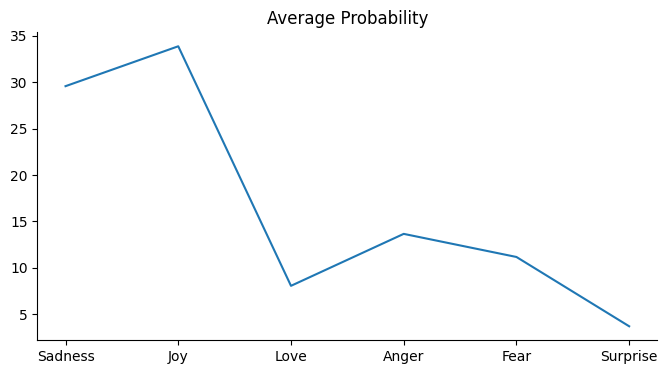

In [22]:
# @title Average Probability

from matplotlib import pyplot as plt
result['Average Probability'].plot(kind='line', figsize=(8, 4), title='Average Probability')
plt.gca().spines[['top', 'right']].set_visible(False)

In [19]:
def readFromTxt(route):
    #first u have to open  the file and seperate every line like below:

    file = open(route, "r")
    lines = file.readlines()
    file.close()
    # remove /n at the end of each line
    for index, line in enumerate(lines):
      lines[index] = line.strip()
    #creating a dataframe
    df_result = pd.DataFrame(columns=('text'))
    #Assigning rows to the dataframe
    df_result['text'] = lines
    return df_result



In [29]:
def tokenizeDF(dataframe):
    # lowercase, digits and extra-spaces
    dataframe["t_text"] = dataframe["text"].str.lower()
    dataframe["t_text"] = dataframe["t_text"].apply(lambda x: re.sub(r"\d+","",x))
    dataframe["t_text"] = dataframe["t_text"].apply(lambda x: re.sub(r"\s+"," ",x))

    # links and special characters
    dataframe["t_text"] = dataframe["t_text"].apply(lambda x: re.sub(r"http\S+","",x))
    dataframe["t_text"] = dataframe["t_text"].apply(lambda x: re.sub(r"[^\w\s]","",x))

    #Tokenization and removing puntuation
    dataframe["t_text"] = dataframe["t_text"].apply(lambda x:word_tokenize(x))
    dataframe["t_text"] = dataframe["t_text"].apply(lambda items:[item for item in items if item not in punctuation])

    #Stop words
    stop_words = stopwords.words("english")
    com_stop_words = stop_words + list(STOP_WORDS) + list(STOPWORDS)
    print(len(com_stop_words))
    print(len(set(com_stop_words)))

    dataframe["t_text"] = dataframe["t_text"].apply(lambda words:[word for word in words if word not in com_stop_words])
    #Lemmatization
    lem = WordNetLemmatizer()
    dataframe["t_text"] = dataframe["t_text"].apply(lambda words:" ".join([lem.lemmatize(word,pos="v") for word in words]))
    return dataframe



In [41]:
def characteristicsExtraction(X_val):
    with open('./tfidf_vectorizer.pkl', 'rb') as f:
      tfidf_vectorizer  = pickle.load(f)
      X_val  = pd.DataFrame(tfidf_vectorizer.transform(X_val).toarray())
      X_val.columns = tfidf_vectorizer.get_feature_names_out()
      return X_val



In [33]:
df = readFromTxt('./test.txt')
print(df.head())
print('tokenize')
df = tokenizeDF(df)
print(df.head())

                                      text label
0            Hi i am so happy about being,   NaN
1           the first text to be processed   NaN
2                  in this exciting model.   NaN
3  I am so anxious about what will happen.   NaN
tokenize
697
418
                                      text label          t_text
0            Hi i am so happy about being,   NaN        hi happy
1           the first text to be processed   NaN    text process
2                  in this exciting model.   NaN    excite model
3  I am so anxious about what will happen.   NaN  anxious happen


In [47]:
X_test = characteristicsExtraction(df['t_text'])
print('--------')
print(X_test.head())
y_test = emotions3_model.predict(X_test)

--------
   aaron   ab  abandon  abandonment  abby  abc  abdomen  abe  abide  \
0    0.0  0.0      0.0          0.0   0.0  0.0      0.0  0.0    0.0   
1    0.0  0.0      0.0          0.0   0.0  0.0      0.0  0.0    0.0   
2    0.0  0.0      0.0          0.0   0.0  0.0      0.0  0.0    0.0   
3    0.0  0.0      0.0          0.0   0.0  0.0      0.0  0.0    0.0   

   abilities  ...  zambia  zap  zen  zero  zip  zombie  zone  zoo  zoom  zumba  
0        0.0  ...     0.0  0.0  0.0   0.0  0.0     0.0   0.0  0.0   0.0    0.0  
1        0.0  ...     0.0  0.0  0.0   0.0  0.0     0.0   0.0  0.0   0.0    0.0  
2        0.0  ...     0.0  0.0  0.0   0.0  0.0     0.0   0.0  0.0   0.0    0.0  
3        0.0  ...     0.0  0.0  0.0   0.0  0.0     0.0   0.0  0.0   0.0    0.0  

[4 rows x 8000 columns]


In [48]:
getResults(y_test,X_test,emotions3_model)

         Average Probability
Sadness                 5.90
Joy                    56.30
Love                    2.26
Anger                   6.03
Fear                   28.20


,Average Probability
Sadness,5.90
Joy,56.30
Love,2.26
Anger,6.03
Fear,28.20
Surprise,1.31
